In [51]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
from shapely import geometry

import sys
sys.path.append('..')

from phase_o_matic.download import download_era
from phase_o_matic.preprocess import get_vapor_partial_pressure, convert_pressure_to_pascals, interpolate_to_heights
from phase_o_matic.phase_delay import calculate_refractive_indexes, integrate_refractivity

In [45]:
# interpolate delays to uavsar
geom = xr.open_dataset('../data/uavsar/uavsar_geom_v2.nc').sel(heading = '232')
if 'x' in geom.coords: geom = geom.rename({'x':'longitude'})
if 'y' in geom.coords: geom = geom.rename({'y':'latitude'})
geom['dem'] = geom['dem'].where(geom['dem'] > 0)
time1 = pd.to_datetime('2021-01-15 19:50:49 UTC').tz_convert('America/Boise')
time2 = pd.to_datetime('2021-01-20 21:20:42 UTC').tz_convert('America/Boise')
time_DAs = []
for time in [time1, time2]:
    # fp = download_era(date = time, out_dir = '../data/', subset = geometry.box(*geom.rio.bounds()), LOS = False)
    fp = f"/Users/zachkeskinen/Documents/phase-o-matic/data/ERA5_{time.strftime('%Y-%m-%dT%H')}:00_-116.31_43.59_-114.90_44.46.nc"
    era = xr.open_dataset(fp) #'../data/ERA5_2021-01-15T12:00_-116.31_43.59_-114.90_44.46.nc'
    era = convert_pressure_to_pascals(era)
    era = get_vapor_partial_pressure(era)
    max_alt = (geom['dem'] + np.abs(geom['lkv_z'])).max()
    ds = interpolate_to_heights(era, max_alt = max_alt)
    ds = calculate_refractive_indexes(ds)
    # new stuff below
    # ds = ds.interp_like(geom, method = 'linear', kwargs={"fill_value": "extrapolate"})
    # ds = ds.interp(height = np.round(np.arange(geom['dem'].min()-2, geom['dem'].max()+2)), method = 'linear')
    time_DAs.append(ds)
ds = xr.concat(time_DAs, dim = 'time')

In [90]:
import numpy as np
import xarray as xr
from scipy import integrate
def integrate_refractivity(dataset: xr.Dataset) -> xr.Dataset:
    """
    Integrate combined refractivity through atmosphere from high to low.
    
    Args:
    dataset: xarray dataset with combined refractivity and heights (m)

    Returns:
    dataset: xarray dataset with cumulative integrated refractivity added
    """
    # check if heights are increasing
    if np.all(np.diff(dataset.height, 1) > 0):
        # reverse heights so we integrate from satellite to ground (high -> low)
        dataset = dataset.reindex(height=list(reversed(dataset.height)))
    # calculate integrated refractivity index from high to low at each lat, long
    integrated_N = integrate.cumtrapz(dataset['N'], x = dataset['height'], initial = 0)
    # insert as new variable cumulative refractivity index
    dataset['cum_N'] = (['time', 'longitude', 'latitude', 'height'], integrated_N)

    return dataset

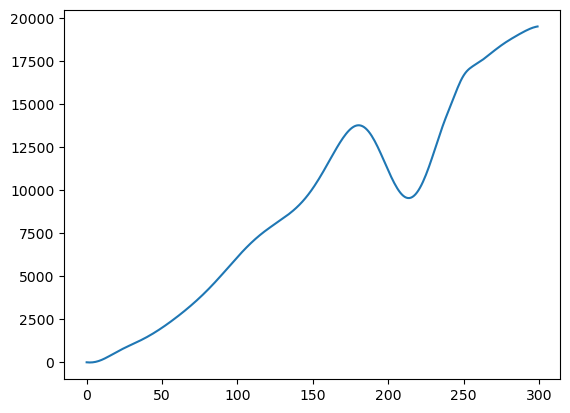

In [94]:
cum = integrate.cumtrapz(ds['N'], x = ds['height'], initial = 0, axis = -1)
plt.plot(cum[1, 3, 2] - cum[0, 3, 2])

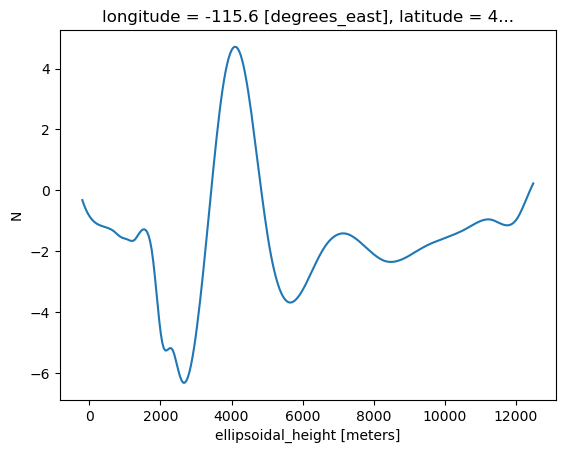

In [68]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
((ds['N'].isel(time = 1).isel(longitude = 3, latitude = 2) - ds['N'].isel(time = 0).isel(longitude = 3, latitude = 2))).plot(ax = ax)


In [ ]:
# https://stackoverflow.com/questions/53350391/surface-normal-calculation-from-depth-map-in-python
from rasterio.enums import Resampling
if geom.rio.crs != geom.rio.estimate_utm_crs():
    geom = geom.rio.reproject(geom.rio.estimate_utm_crs(), nodata = np.nan, resampling = Resampling.bilinear)
d_im = geom['dem'].data
x_scaling = (geom.x[1] - geom.x[0]).data.ravel()[0]
y_scaling = (geom.y[1] - geom.y[0]).data.ravel()[0]
zy, zx = np.gradient(d_im)
normal = np.dstack((-zx/x_scaling, -zy/y_scaling, np.ones_like(d_im)))
n = np.linalg.norm(normal, axis=2)
normal[:, :, 0] /= n
normal[:, :, 1] /= n
normal[:, :, 2] /= n

geom['mag'] = (geom['lkv_x']**2 + geom['lkv_y']**2 + geom['lkv_z']**2)**0.5
rls = np.zeros_like(geom['dem'])
rls = np.repeat(np.expand_dims(rls, axis = 2), 3, axis = 2)
rls = np.dstack((geom['lkv_x'], geom['lkv_y'], geom['lkv_z']))
rls[:,:, 0] /= geom['mag']
rls[:,:, 1] /= geom['mag']
rls[:,:, 2] /= geom['mag']

inc = np.zeros(geom['dem'].shape)
for i in range(rls.shape[0]):
    for j in range(rls.shape[1]):
        inc[i, j] = np.arccos(np.dot(-normal[i, j], rls[i, j]))

geom['inc'] = xr.DataArray(inc, coords = [geom.y, geom.x], dims = ['y','x'])

if geom.rio.crs != 'EPSG:4326':
    geom = geom.rio.reproject('EPSG:4326', nodata = np.nan, resampling = Resampling.bilinear)
geom['dem_int'] = xr.apply_ufunc(np.round, geom['dem'])